# Exercise 5 - Variational quantum eigensolver


### References
+ [Rattew *et al.*,2019](https://arxiv.org/abs/1910.09694)
+ [Qiskit Global Summer School Lab-8](https://www.youtube.com/watch?v=3B04KB0pDwE)
+ [Coding with Qiskit VQE](https://www.youtube.com/watch?v=Z-A6G0WVI9w)

***Name:*** Lakshmi Siri Appalaneni<br/>
***Score:*** 3<br/>
***Chemical accuracy:*** 2.358814<br/>
***Number of ansatz parameters:*** 16

# VQE for LiH molecule 



Simulate LiH molecule using the STO-3G basis with the PySCF driver

In [2]:
from qiskit_nature.drivers import PySCFDriver

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule, basis='sto3g')
qmolecule = driver.run()

print(qmolecule.one_body_integrals) # orbitals. Therefore, can be used to analyse which orbitals to be removed

[[-4.73853724  0.10753914  0.1675853   0.          0.         -0.03026284
   0.          0.          0.          0.          0.          0.        ]
 [ 0.10753914 -1.51317577  0.03434669  0.          0.         -0.06802917
   0.          0.          0.          0.          0.          0.        ]
 [ 0.1675853   0.03434669 -1.12916229  0.          0.          0.03143223
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         -1.14077094  0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -1.14077094  0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.03026284 -0.06802917  0.03143223  0.          0.         -0.9418187
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -4.73853724  0.10753914  0.1675853   0.          0.    

#### 2. Electronic structure problem

Create an `ElectronicStructureProblem` that can produce the list of fermionic operators before mapping them to qubits (Pauli strings).

By Using the `FreezeCoreTransformer` we eliminate unnecessary orbitals from the molecular model, which later resuts in a smaller number of qubits in a quantum simulation of the molecule. Hence, We achieve this by freezing core orbitals and removing vacant orbitals.

So in this case orbitals with index [3,4] can be removed as these orbitals with high energy do not interact much with the other orbital systems.



In [3]:
# WRITE YOUR CODE BETWEEN THESE LINES - START
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers import FreezeCoreTransformer
problem = ElectronicStructureProblem(driver, q_molecule_transformers=[FreezeCoreTransformer(True,[3,4])]) 

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

#### 3. QubitConverter

With the help of `ParityMapper` and `two_qubit_reduction=True` we can eleminate 2 qubits.

The specified Z2 symmetries can be explicitly removed by relying on the list of tapering values (Here [1,-1]). Later the list of tapering values is set to null and no further qubit reduction is possible.

And Finally the No.of Qubits is 4.

In [4]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper 
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'
mapper = ParityMapper()

converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1,-1])

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

pauli_symm = converter.z2symmetries.find_Z2_symmetries(qubit_op)
print(pauli_symm, '\n')
print('No of qubits: ', qubit_op.num_qubits)

Z2 symmetries:
Symmetries:
Single-Qubit Pauli X:
Cliffords:
Qubit index:
[]
Tapering values:
  - Possible values: [] 

No of qubits:  4


#### 4. Initial state
As described in the Theory section, a good initial state in chemistry is the HF state (i.e. $|\Psi_{HF} \rangle = |0101 \rangle$). We can initialize it as follows:

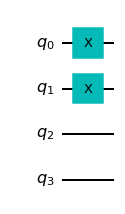

In [5]:
from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals 
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
init_state.draw()

#### 5. Ansatz
One of the most important choices is the quantum circuit that you choose to approximate your ground state.


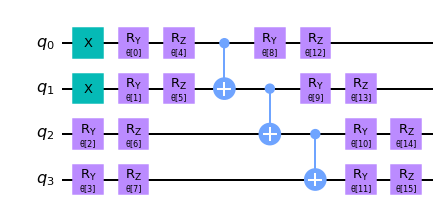

In [6]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Choose the ansatz
ansatz_type = "TwoLocal"

# Parameters for q-UCC antatze
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry','rz']
    # Entangling gates
    entanglement_blocks = 'cx'
    # How the qubits are entangled 
    entanglement = 'linear' # among 'sca' or 'circular' or 'full', Linear produces min. CNOTS.
    # Repetitions set to 1 to keep the ansatz small.
    repetitions = 1
    skip_final_rotation_layer = False
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
ansatz.draw()

#### 6. Backend
This is where you specify the simulator or device where you want to run your algorithm.
We will focus on the `statevector_simulator` in this challenge.


In [7]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

#### 7. Optimizer

The optimizer guides the evolution of the parameters of the ansatz so it is very important to investigate the energy convergence as it would define the number of measurements that have to be performed on the QPU.

Several optimisers have been tested, the best results were obtained with SLSQP.

In [8]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'SLSQP'
optimizer = SLSQP(maxiter=500)

#### 8. Exact eigensolver

In [9]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)


Exact electronic energy -1.0887060157347404
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.907396311316
  - computed part:      -1.088706015735
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.881461431673
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.76300889]
    - computed part:      [0.0  0.0  4.76695575]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.83884668]  Total: 1.83884668
                 (debye): [0.0  0.0  -4.67388163]  Total: 4.67388163
 


#### 9. VQE and initial parameters for the ansatz
Now we can import the VQE class and run the algorithm.

In [10]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 786,
    'eigenstate': array([ 1.39106247e-03+1.62876781e-04j, -4.80413721e-03-1.47039142e-04j,
        2.62454202e-02+8.47616598e-04j, -9.91330288e-01+1.36840820e-02j,
       -5.37456569e-02-3.77344148e-03j, -3.69294278e-04-8.90800364e-05j,
        8.79343302e-04-4.46584563e-06j, -2.32778600e-02+1.49221434e-03j,
       -2.67384353e-03-7.05418364e-05j, -1.11979373e-05-8.32005597e-06j,
        3.67268850e-06+2.34897965e-05j,  3.09770638e-04-9.10926038e-04j,
        1.13571944e-01-2.69535175e-03j,  5.55461870e-04+1.40857863e-04j,
       -5.49461154e-04+3.83307647e-05j, -2.91925097e-05-1.94194736e-05j]),
    'eigenvalue': -1.0863472016458622,
    'optimal_parameters': {   ParameterVectorElement(θ[5]): 0.028610944621781067,
                              ParameterVectorElement(θ[10]): 3.1886725491894543,
                              ParameterVectorElement(θ[4]): -0.04518288755520494,
                              ParameterVec

#### 9. Scoring function 
We need to judge how good are your VQE simulations, your choice of ansatz/optimizer.
For this, we implemented the following simple scoring function:

$$ score = N_{CNOT}$$

where $N_{CNOT}$ is the number of CNOTs.

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,SLSQP,TwoLocal,4,16,"[ry, rz]",cx,linear,1,2.358814,True,3


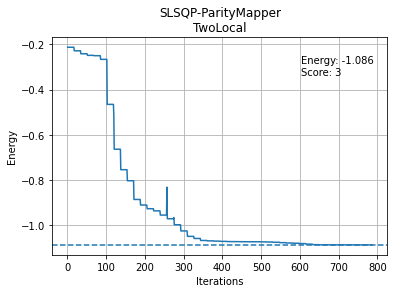

In [11]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

In [12]:
# Check your answer using following code
from qc_grader import grade_ex5
freeze_core = True # change to True if you freezed core electrons
grade_ex5(ansatz,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 3.
Feel free to submit your answer.



In [13]:
# Submit your answer. You can re-submit at any time.
from qc_grader import submit_ex5
submit_ex5(ansatz,qubit_op,result,freeze_core)

Submitting your answer for ex5. Please wait...
Failed: Error wrong data received.


## Additional information

**Created by:** Igor Sokolov, Junye Huang, Rahul Pratap Singh

**Version:** 1.0.0